# Notebook for unit tests

In [1]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import chisquare
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re
import rpy2

# Create R interface
# from rpy2.robjects.packages import importr
# import rpy2.robjects as ro

# stats = importr("stats")
# base = importr("base")

# Disable max row error
alt.data_transformers.disable_max_rows()

# Set Seaborn style
sns.set(style="whitegrid")
plt.style.use("ggplot")
sns.set_context("talk")
%matplotlib inline

## Test A1: Genetic drift and random mating

In [2]:
# Define the arrays containing results from
# simulation
files = [
    "a1simP10.pickle",
    "a1simP30.pickle",
    "a1simP50.pickle",
    "a1simP70.pickle",
    "a1simP100.pickle",
    "a1simP150.pickle",
    "a1simP200.pickle",
    "a1simP300.pickle",
    "a1simP400.pickle",
    "a1simP500.pickle",
]

prefix = "a1sim"
suffix = ".pickle"

# Define total number of simulations
totalSims = 100000

# Define max generation
maxGen = 100000

# Make sure that popSize is in same order
# as files array - 1st file should correspond
# to first popSize (population size)
popSize = np.asarray([10, 30, 50, 70, 100, 150, 200, 300, 400, 500])

# Load results from all the runs
# The results are stored as pickle
# files. Each containing a list of
# tuples
# Also create dataframes for each
# simulation run

columns = ["State", "Generations", "Transpositions"]
DataFrameSim = []
SimulationResults = {}
for filename in files:
    with open(filename, "rb") as f:
        SimulationResults[
            filename.replace(suffix, "").replace(prefix, "")
        ] = pickle.load(f)
        DataFrameSim.append(
            pd.DataFrame(
                [
                    x
                    for x in SimulationResults[
                        filename.replace(suffix, "").replace(
                            prefix, ""
                        )
                    ]
                ],
                columns=columns,
            )
        )

In [3]:
# Calculate reference statistics
refFrequency = 1 / (2 * popSize)
refFixation = popSize * 4
refFixSD = popSize * 2.15
refLoss = 2 * np.log(2 * popSize)

In [4]:
# Calculate simulation statistics
obsFrequency = []
obsFixation = []
obsFixSD = []
obsLoss = []
chisqr = []
chisqrCore = []
counter = 0
for df in DataFrameSim:
    dfFull = df[df["State"] == 1]
    dfLoss = df[df["State"] == 0]
    obsFrequency.append(dfFull.shape[0] / totalSims)
    obsFixation.append(dfFull["Generations"].mean())
    obsFixSD.append(dfFull["Generations"].std())
    obsLoss.append(dfLoss["Generations"].mean())
    chisqr.append(
        chisquare(
            [dfLoss.shape[0], dfFull.shape[0]],
            f_exp=[
                totalSims * (1 - refFrequency[counter]),
                totalSims * (refFrequency[counter]),
            ],
        )[0]
    )
    chisqrCore.append(
        chisquare(
            [dfLoss.shape[0], dfFull.shape[0]],
            f_exp=[
                totalSims * (1 - refFrequency[counter]),
                totalSims * (refFrequency[counter]),
            ],
        )
    )
    counter += 1
obsFrequency = np.asarray(obsFrequency)
obsFixation = np.asarray(obsFixation)
obsFixSD = np.asarray(obsFixSD)
obsLoss = np.asarray(obsLoss)

Text(0.5, 1.0, 'Observed frequency of TE fixation vs expected(1/2N)')

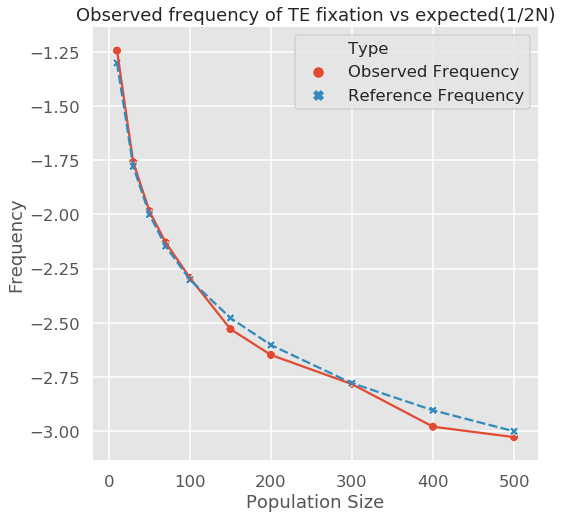

In [5]:
# Plot observed frequency vs expected frequency
# Creating a long form dataframe to do so
linePlotDF = pd.DataFrame(
    {
        "Population Size": popSize,
        "Observed Frequency": np.log10(obsFrequency),
        "Reference Frequency": np.log10(refFrequency),
    }
)

linePlotDF = pd.melt(
    linePlotDF,
    id_vars=["Population Size"],
    value_vars=["Observed Frequency", "Reference Frequency"],
)
linePlotDF.columns = ["Population Size", "Type", "Frequency"]

plt.figure(figsize=(8, 8))

sns.lineplot(
    x="Population Size",
    y="Frequency",
    hue="Type",
    style="Type",
    data=linePlotDF,
    legend=False,
)
sns.scatterplot(
    x="Population Size",
    y="Frequency",
    hue="Type",
    style="Type",
    data=linePlotDF,
).set_title("Observed frequency of TE fixation vs expected(1/2N)")

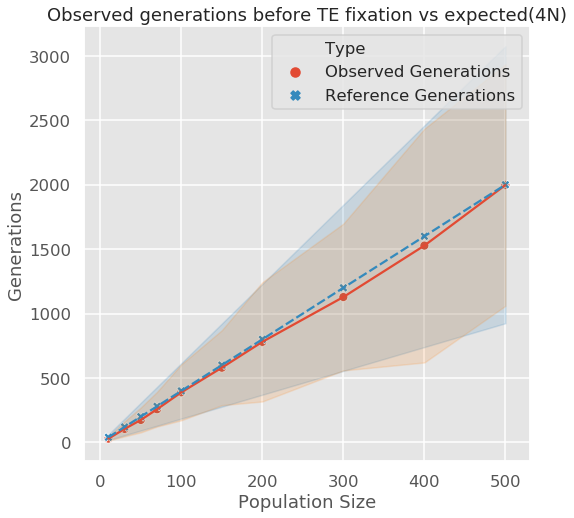

In [6]:
# Plot observed time for TE fixation vs expected
# Creating a long form dataframe to do so
linePlotDF = pd.DataFrame(
    {
        "Population Size": popSize,
        "Observed Generations": obsFixation,
        "Reference Generations": refFixation,
    }
)

linePlotDF = pd.melt(
    linePlotDF,
    id_vars=["Population Size"],
    value_vars=["Observed Generations", "Reference Generations"],
)
linePlotDF.columns = ["Population Size", "Type", "Generations"]

plt.figure(figsize=(8, 8))

sns.lineplot(
    x="Population Size",
    y="Generations",
    hue="Type",
    style="Type",
    data=linePlotDF,
    legend=False,
).set_title("Observed generations before TE fixation vs expected(4N)")
ax = sns.scatterplot(
    x="Population Size",
    y="Generations",
    hue="Type",
    style="Type",
    data=linePlotDF,
)

ax.fill_between(
    popSize,
    y1=refFixation - refFixSD,
    y2=refFixation + refFixSD,
    alpha=0.15,
    color="tab:blue",
)

ax.fill_between(
    popSize,
    y1=obsFixation - obsFixSD,
    y2=obsFixation + obsFixSD,
    alpha=0.15,
    color="tab:orange",
)

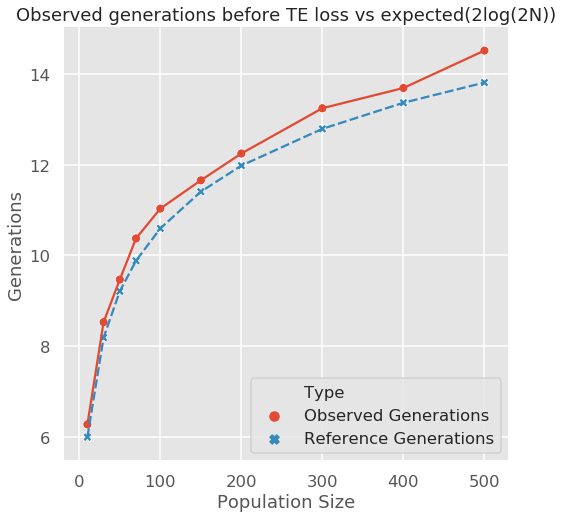

In [7]:
# Plot observed time for TE loss vs expected
# Creating a long form dataframe to do so
linePlotDF = pd.DataFrame(
    {
        "Population Size": popSize,
        "Observed Generations": obsLoss,
        "Reference Generations": refLoss,
    }
)

linePlotDF = pd.melt(
    linePlotDF,
    id_vars=["Population Size"],
    value_vars=["Observed Generations", "Reference Generations"],
)
linePlotDF.columns = ["Population Size", "Type", "Generations"]

plt.figure(figsize=(8, 8))

sns.lineplot(
    x="Population Size",
    y="Generations",
    hue="Type",
    style="Type",
    data=linePlotDF,
    legend=False,
).set_title(
    "Observed generations before TE loss vs expected(2log(2N))"
)

sns.scatterplot(
    x="Population Size",
    y="Generations",
    hue="Type",
    style="Type",
    data=linePlotDF,
)

In [8]:
obsLoss

array([ 6.27230405,  8.52919385,  9.46864516, 10.37498615, 11.0338426 ,
       11.65780711, 12.24958156, 13.2488506 , 13.69493969, 14.52072949])

In [9]:
refLoss

array([ 5.99146455,  8.18868912,  9.21034037,  9.88328485, 10.59663473,
       11.40756495, 11.98292909, 12.79385931, 13.36922346, 13.81551056])

Text(0.5, 1.0, 'Chi-square stastics for simulated populations')

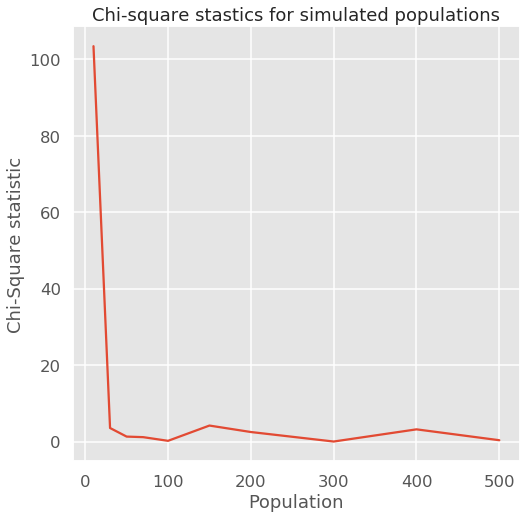

In [10]:
# Plot chisquare statistics

plt.figure(figsize=(8, 8))
ax = sns.lineplot(x=popSize, y=chisqr,)
ax.set(ylabel="Chi-Square statistic", xlabel="Population")
ax.set_title("Chi-square stastics for simulated populations")

In [11]:
chisqrCore

[Power_divergenceResult(statistic=103.45284210526316, pvalue=2.666665478935278e-24),
 Power_divergenceResult(statistic=3.5553220338982903, pvalue=0.05935478976151164),
 Power_divergenceResult(statistic=1.309090909090909, pvalue=0.2525593171851649),
 Power_divergenceResult(statistic=1.162618705035979, pvalue=0.28092310541372806),
 Power_divergenceResult(statistic=0.20100502512562815, pvalue=0.6539108387814259),
 Power_divergenceResult(statistic=4.1953177257525125, pvalue=0.040535756598403014),
 Power_divergenceResult(statistic=2.506265664160401, pvalue=0.11339435127837848),
 Power_divergenceResult(statistic=0.016694490818030587, pvalue=0.8971937289357101),
 Power_divergenceResult(statistic=3.2040050062578223, pvalue=0.0734581772328101),
 Power_divergenceResult(statistic=0.36036036036036034, pvalue=0.5483061686853479)]

In [10]:
refLoss

array([2.60205999, 3.5563025 , 4.        , 4.29225607, 4.60205999,
       4.95424251, 5.20411998, 5.5563025 , 5.80617997, 6.        ,
       6.29225607])

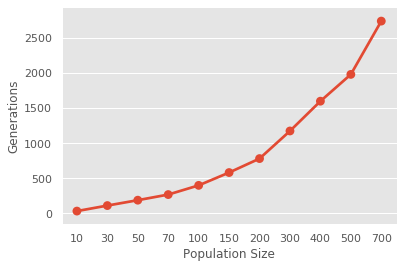

In [16]:
sns.pointplot(
    x="Population Size", y="Generations", errwidth=0, data=linePlotDF
)

## Test B1: Genetic drift, random mating, and recombination

In [39]:
# Define dataframe columns
# State defines the exit state for simulation instance
# where 0 = Transposon lost in all members of population
# and 1 = transposon fixed in all members of population
# and 2 = maximum generations reached without fixation or
# loss
columns = [
    "State",
    "FixedTe",
    "TransientTE",
    "LostTE",
    "Generation",
    "TranspositionEvents",
]

# Read the simulation results
with open("b1P200C0-1.pickle", "rb") as f:
    b1Sim = pickle.load(f)

# Intialize dataframe
b1SimDF = pd.DataFrame([x for x in b1Sim], columns=columns)

# Parition dataframe based on loss or gain of transposon
b1SimDFFull = b1SimDF[b1SimDF["State"] == "FIXED"]
b1SimDFLoss = b1SimDF[b1SimDF["State"] == "LOSS"]

In [36]:
a = pd.Series([item for sublist in b1SimDF["FixedTe"] for item in sublist])
df = a.value_counts().sort_index().rename_axis('x').reset_index(name='f')

In [41]:
b1SimDFFull

,State,FixedTe,TransientTE,LostTE,Generation,TranspositionEvents
28,FIXED,[2],[],[2353],2355,2.0
217,FIXED,[2],[],[713],715,2.0
320,FIXED,[2],[],[1348],1350,2.0
636,FIXED,[1],[],[352],354,2.0
711,FIXED,[1],[],[492],494,2.0
...,...,...,...,...,...,...
98973,FIXED,[2],[],[672],674,2.0
99171,FIXED,[2],[],[624],626,2.0
99479,FIXED,[2],[],[1357],1359,2.0
99567,FIXED,[2],[],[409],411,2.0
